In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
from quagmire import SurfaceProcessMesh
%matplotlib inline



In [74]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.005, 0.005

x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 100000, 1000)
x, y = meshtools.lloyd_mesh_improvement(x, y, bmask, 5)

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0


In [79]:
DM = meshtools.create_DMPlex_from_points(x, y, bmask)
sp = SurfaceProcessMesh(DM)

 - Delaunay triangulation 2.382146s
 - cKDTree 0.02535s
 - Calculate node weights and area 1.334226s
 - Compute edge lengths 0.167658s
 - Construct nearest neighbour array 0.572219s
 - Construct neighbour cloud array 0.513844s
 - Find boundaries 0.0178060000001s
 - Build smoothing matrix 0.037568s


In [83]:
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)

# height  = np.exp(-0.01 *(x**2 + y**2)**2) + 0.25 * (0.2*radius)**8  * np.cos(30.0*theta)**2 ## Concentrated
height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(10.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)

# height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001
height += np.random.random(height.size) * 0.01 # random noise

sp.update_height(height)


rain   = height**2
sp.update_surface_processes(rain, np.zeros_like(rain))

 - Sort nodes by field 0.189482s
 - Build downhill matrices 0.512354s
 - Cumulative flow 0.3153s


In [84]:
def compute_stream_power(self, m=1, n=1):
    """
    Stream power law (q_s)
    """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain / self.area
    stream_power = cumulative_flow_rate**m *self.slope**n
    return stream_power

stream_power = compute_stream_power(sp, m=1, n=1)

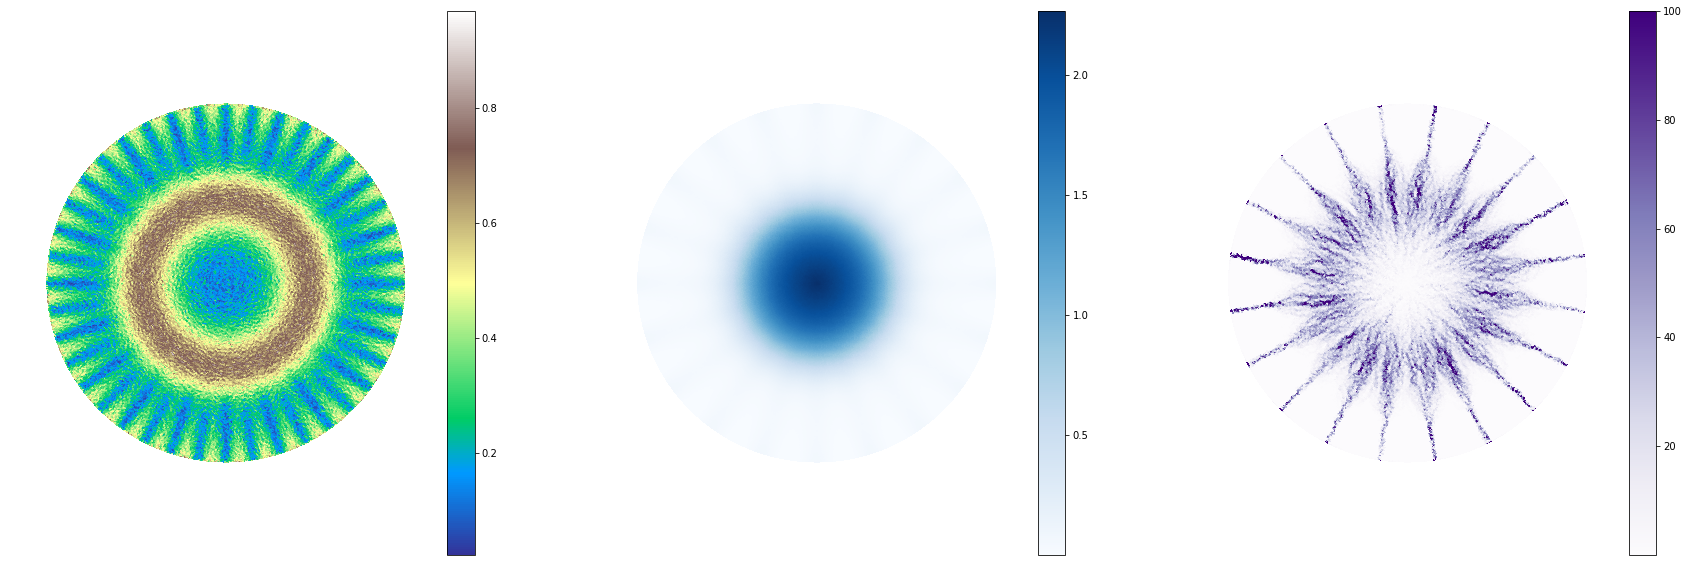

In [85]:
# Plot the height, rainfall, and stream power

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
im1 = ax1.tripcolor(x, y, sp.tri.simplices, sp.slope,     cmap='terrain')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, rain,         cmap='Blues')
im3 = ax3.tripcolor(x, y, sp.tri.simplices, stream_power, cmap='Purples', vmax=100.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

In [86]:
# Distance-weighted averages


def _inv_dist_w(mesh, delta=None, power=1.0):
    
    # mean near-neighbour distance
    
    if delta == None:
        delta = mesh.neighbour_cloud_distances[:,1].mean() * 0.5

    inv_dist_w = np.ones_like(mesh.neighbour_cloud_distances)
    
    inv_dist_w[:,1:] = np.power(delta / mesh.neighbour_cloud_distances[:,1:], power)
    inv_dist_w = np.minimum(1.0, inv_dist_w)
    inv_dist_w[:,:] /= inv_dist_w.sum(axis=1).reshape(-1,1)
    
    inv_dist_wc = inv_dist_w.copy()
    inv_dist_wc[:,0] = 0.0
    inv_dist_wc /= inv_dist_wc.sum(axis=1).reshape(-1,1)
        
    return inv_dist_w, inv_dist_wc


def _gaussian_dist_w(mesh, delta=None, power=1.0):
    
    # mean near-neighbour distance
    
    if delta == None:
        delta = mesh.neighbour_cloud_distances[:,1].mean() * 0.5

    gaussian_dist_w       = np.zeros_like(mesh.neighbour_cloud_distances)
    gaussian_dist_w[:,:]  = np.exp(-np.power(mesh.neighbour_cloud_distances[:,:]/delta, 2.0))
    gaussian_dist_w[:,:] /= gaussian_dist_w.sum(axis=1).reshape(-1,1)
      
    return gaussian_dist_w

def _gaussian_dist_wxy(mesh, delta=None, power=1.0):
    
#     # mean near-neighbour distance
    
    if delta == None:
        delta = mesh.neighbour_cloud_distances[:,1].mean() * 0.5

    g_dist_w  = _gaussian_dist_w(mesh, delta, power)
    
    dx = np.zeros_like(mesh.neighbour_cloud_distances)
    dy = np.zeros_like(mesh.neighbour_cloud_distances)
    
    for node in range(0, mesh.npoints):
        dx[node,:] = mesh.tri.points[node,0] - mesh.tri.points[mesh.neighbour_cloud[node,:],0]
        dy[node,:] = mesh.tri.points[node,1] - mesh.tri.points[mesh.neighbour_cloud[node,:],1]

    
    gaussian_dx_w = -(2.0/delta**2) * dx * g_dist_w
    gaussian_dy_w = -(2.0/delta**2) * dy * g_dist_w
    
#     gaussian_dx_w[:,:] += gaussian_dx_w.sum(axis=1).reshape(-1,1)
#     gaussian_dy_w[:,:] += gaussian_dy_w.sum(axis=1).reshape(-1,1)
   
    return gaussian_dx_w, gaussian_dy_w


def gaussian_dx(mesh, delta=None, ddelta=None):
    """
    Compute the gaussian weights for x-dx, x+dx and therefore, d/dx
    """
    
    if delta == None:
        delta = mesh.neighbour_cloud_distances[:,1].mean() * 2.0
        print "Using $\delta$ = ", delta
    
    if ddelta == None:
        ddelta =  mesh.neighbour_cloud_distances[:,1].mean() * 0.25

    gaussian_dist_w = np.zeros_like(mesh.neighbour_cloud_distances)
    dxminus         = np.zeros_like(mesh.neighbour_cloud_distances)
    dxplus          = np.zeros_like(mesh.neighbour_cloud_distances)
    dyminus         = np.zeros_like(mesh.neighbour_cloud_distances)
    dyplus          = np.zeros_like(mesh.neighbour_cloud_distances)
    dx              = np.zeros_like(mesh.neighbour_cloud_distances)
    dy              = np.zeros_like(mesh.neighbour_cloud_distances)


    for node in range(0, mesh.npoints):
        dxminus[node,:] = mesh.tri.points[node,0] - mesh.tri.points[mesh.neighbour_cloud[node,:],0] - ddelta * 0.5
        dxplus[node,:]  = dxminus[node,:] + ddelta

        dyminus[node,:] = mesh.tri.points[node,1] - mesh.tri.points[mesh.neighbour_cloud[node,:],1] - ddelta * 0.5
        dyplus[node,:]  = dyminus[node,:] + ddelta

        dx[node] = mesh.tri.points[node,0] - mesh.tri.points[mesh.neighbour_cloud[node,:],0]
        dy[node] = mesh.tri.points[node,1] - mesh.tri.points[mesh.neighbour_cloud[node,:],1]

    distminus = np.hypot(dxminus, dy)
    distplus  = np.hypot(dxplus,  dy)
    gaussian_dist_wxm  = np.exp(-np.power(distminus[:,:]/delta, 2.0))
    gaussian_dist_wxm /= gaussian_dist_wxm.sum(axis=1).reshape(-1,1)
    gaussian_dist_wxp  = np.exp(-np.power(distplus[:,:]/delta, 2.0))
    gaussian_dist_wxp /= gaussian_dist_wxp.sum(axis=1).reshape(-1,1)

    gaussian_ddx = (gaussian_dist_wxp - gaussian_dist_wxm)/ddelta

    distminus = np.hypot(dx, dyminus)
    distplus  = np.hypot(dx, dyplus)
    gaussian_dist_wym  = np.exp(-np.power(distminus[:,:]/delta, 2.0))
    gaussian_dist_wym /= gaussian_dist_wym.sum(axis=1).reshape(-1,1)
    gaussian_dist_wyp  = np.exp(-np.power(distplus[:,:]/delta, 2.0))
    gaussian_dist_wyp /= gaussian_dist_wyp.sum(axis=1).reshape(-1,1)

    gaussian_ddy = (gaussian_dist_wyp - gaussian_dist_wym)/ddelta

    return gaussian_ddx, gaussian_ddy


def distance_weighted_average(mesh, field, power=1.0, delta=None, dist_w=None):
    
    # mean near-neighbour distance
    
    if delta == None:
        delta = mesh.neighbour_cloud_distances[:,1].mean() * 0.5
        
    if dist_w == None:
        dist_w = _gaussian_dist_w(mesh, delta=delta, power=power)
    
    f2 = (field[mesh.neighbour_cloud[:,:]] * dist_w[:,:]).sum(axis=1)
    
    return f2
    


In [87]:
inv_dist_w, inv_dist_wc  = _inv_dist_w (sp, power=4.0, delta=0.05)
gauss_dist_w = _gaussian_dist_w(sp, power=1.0, delta=0.5)

In [88]:
gauss_dx_w, gauss_dy_w = _gaussian_dist_wxy(sp, power=1.0, delta=0.05 )

In [89]:
gauss_dx_w[0].sum()

1.4616781635331273

In [99]:
h2  = (sp.height[sp.neighbour_cloud[:]] * gauss_dist_w[:,:]).sum(axis=1)
h2x = (sp.height[sp.neighbour_cloud[:]] * gauss_dx_w[:,:]).sum(axis=1)
h2y = (sp.height[sp.neighbour_cloud[:]] * gauss_dy_w[:,:]).sum(axis=1)
h2s = np.hypot(h2x, h2y)

In [100]:
hx, hy = sp.derivative_grad(sp.height)


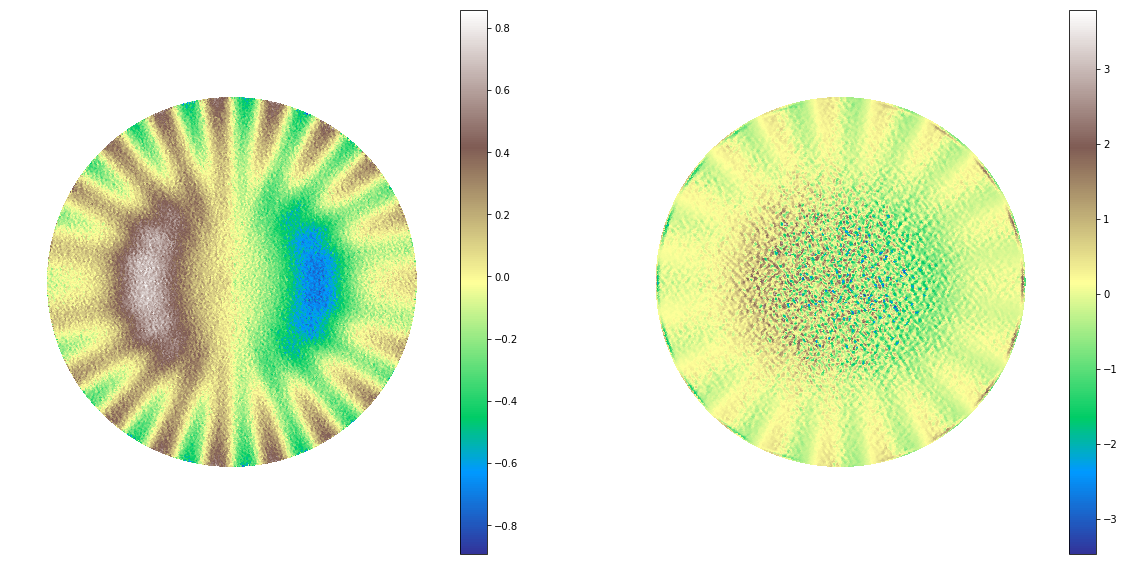

In [103]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, hx,  cmap='terrain')
im2 = ax2.tripcolor(x, y, sp.tri.simplices, h2x,    cmap='terrain')

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

In [104]:
delta = 0.1

mesh = sp

g_dist_w  = _gaussian_dist_w(mesh, delta, 1.0)

dx = np.zeros_like(mesh.neighbour_cloud_distances)
dy = np.zeros_like(mesh.neighbour_cloud_distances)

for node in range(0, mesh.npoints):
    dx[node,:] = sp.tri.points[node,0] - sp.tri.points[mesh.neighbour_cloud[node,:],0]
    dy[node,:] = sp.tri.points[node,1] - sp.tri.points[mesh.neighbour_cloud[node,:],1]


gaussian_dx_w = -(2.0/delta**2) * dx * g_dist_w
gaussian_dy_w = -(2.0/delta**2) * dy * g_dist_w

# gaussian_dx_w[:,:] /= (dx * gaussian_dx_w).sum(axis=1).reshape(-1,1)
# gaussian_dy_w[:,:] /= (dy * gaussian_dy_w).sum(axis=1).reshape(-1,1)


h3  = (sp.height[sp.neighbour_cloud[:]] * gauss_dist_w[:,:]).sum(axis=1)
h3x = (h3[sp.neighbour_cloud[:]] * gaussian_dx_w[:,:]).sum(axis=1)
h3y = (h3[sp.neighbour_cloud[:]] * gaussian_dy_w[:,:]).sum(axis=1)

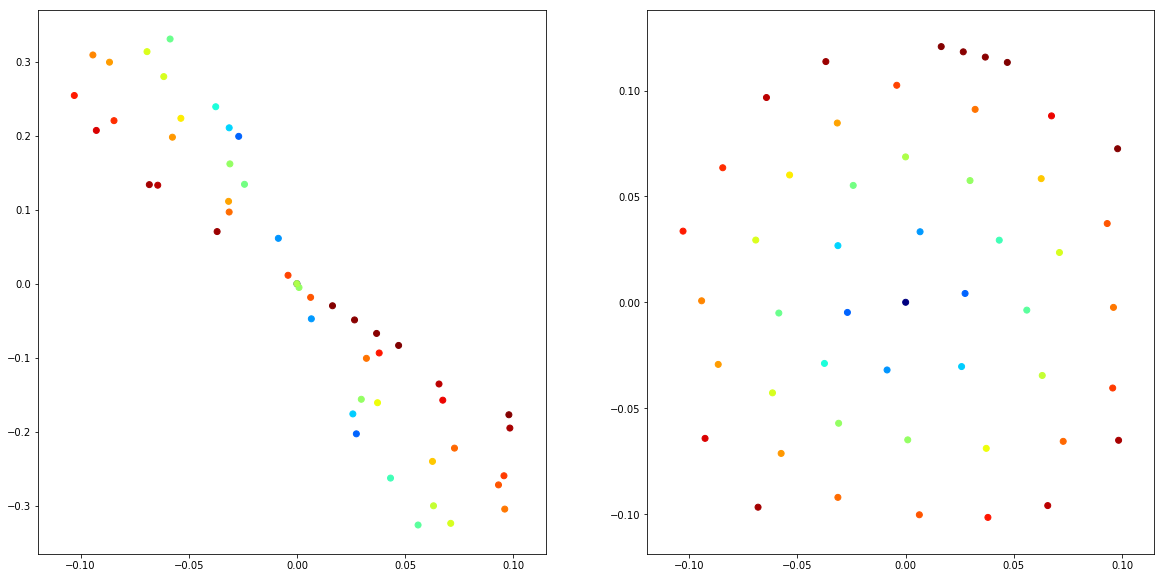

In [105]:
node = 500

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

dist = sp.neighbour_cloud_distances[node,:]
ax1.scatter(dx[node,:], gaussian_dx_w[node,:], c=dist, cmap="jet")
ax2.scatter(dx[node,:], dy[node,:], c=dist, cmap="jet")

In [106]:
np.polyfit(dx[node, 0:10], sp.height[sp.neighbour_cloud[node, 0:10]], 1.0, rcond=None, full=False, w=None, cov=False)

array([ 0.4715927 ,  0.13856854])

In [107]:
h4x = np.empty_like(h3x)
h4y = np.empty_like(h3y)

for node in range(0, sp.npoints):
    h4x[node], blah = np.polyfit(dx[node], sp.height[sp.neighbour_cloud[node]], 1, rcond=None, full=False, w=gauss_dist_w[node], cov=False)
    h4y[node], blah = np.polyfit(dy[node], sp.height[sp.neighbour_cloud[node]], 1, rcond=None, full=False, w=gauss_dist_w[node], cov=False)



In [108]:
# COMPUTE SLOPE FROM LOW NEIGHBOURS


slope  = np.empty_like(h3x)
slope2 = np.empty_like(h3x)
dist = np.empty_like(h3y)
dist2 = np.empty_like(h3y)


for node in range(0, sp.npoints):
    slope[node]  = (-sp.height[sp.down_neighbour1[node]] + sp.height[node])
    slope2[node] = (-sp.height[sp.down_neighbour2[node]] + sp.height[node])

    dist[node]  = np.hypot(sp.tri.points[node,0]-sp.tri.points[sp.down_neighbour1[node],0],
                    sp.tri.points[node,1]-sp.tri.points[sp.down_neighbour1[node],1] )

    dist2[node] = np.hypot(sp.tri.points[node,0]-sp.tri.points[sp.down_neighbour2[node],0],
                    sp.tri.points[node,1]-sp.tri.points[sp.down_neighbour2[node],1] )


valid = np.where(dist != 0.0)
slope[valid] /= dist[valid]
                 
valid = np.where(dist2 != 0.0)
slope2[valid] /= dist2[valid]



In [109]:
if delta == None:
    delta = mesh.neighbour_cloud_distances[:,1].mean() * 2.0

gaussian_dist_w = np.zeros_like(mesh.neighbour_cloud_distances)
dxminus         = np.zeros_like(mesh.neighbour_cloud_distances)
dxplus          = np.zeros_like(mesh.neighbour_cloud_distances)
dyminus         = np.zeros_like(mesh.neighbour_cloud_distances)
dyplus          = np.zeros_like(mesh.neighbour_cloud_distances)
dx              = np.zeros_like(mesh.neighbour_cloud_distances)
dy              = np.zeros_like(mesh.neighbour_cloud_distances)


for node in range(0, mesh.npoints):
    dxminus[node,:] = mesh.tri.points[node,0] - mesh.tri.points[mesh.neighbour_cloud[node,:],0] - delta * 0.5
    dxplus[node,:]  = dxminus[node,:] + delta

    dyminus[node,:] = mesh.tri.points[node,1] - mesh.tri.points[mesh.neighbour_cloud[node,:],1] - delta * 0.5
    dyplus[node,:]  = dyminus[node,:] + delta

    dx[node] = mesh.tri.points[node,0] - mesh.tri.points[mesh.neighbour_cloud[node,:],0]
    dy[node] = mesh.tri.points[node,1] - mesh.tri.points[mesh.neighbour_cloud[node,:],1]
    
distminus = np.hypot(dxminus, dy)
distplus  = np.hypot(dxplus,  dy)
gaussian_dist_wxm  = np.exp(-np.power(distminus[:,:]/delta, 2.0))
gaussian_dist_wxm /= gaussian_dist_wxm.sum(axis=1).reshape(-1,1)
gaussian_dist_wxp  = np.exp(-np.power(distplus[:,:]/delta, 2.0))
gaussian_dist_wxp /= gaussian_dist_wxp.sum(axis=1).reshape(-1,1)

gaussian_ddx = gaussian_dist_wxp - gaussian_dist_wxm

distminus = np.hypot(dx, dyminus)
distplus  = np.hypot(dx, dyplus)
gaussian_dist_wym  = np.exp(-np.power(distminus[:,:]/delta, 2.0))
gaussian_dist_wym /= gaussian_dist_wym.sum(axis=1).reshape(-1,1)
gaussian_dist_wyp  = np.exp(-np.power(distplus[:,:]/delta, 2.0))
gaussian_dist_wyp /= gaussian_dist_wyp.sum(axis=1).reshape(-1,1)

gaussian_ddy = gaussian_dist_wyp - gaussian_dist_wym



In [110]:
mesh.neighbour_cloud_distances[:,1].mean()

0.028812858643913038

In [111]:
dwx, dwy = gaussian_dx(sp, delta=None)

h5x = (sp.height[sp.neighbour_cloud[:]] * dwx[:,:]).sum(axis=1) 
h5y = (sp.height[sp.neighbour_cloud[:]] * dwy[:,:]).sum(axis=1) 

slope5 = np.hypot(h5x,h5y)

Using $\delta$ =  0.0576257172878


In [112]:
for delta1 in (1.0, 1.5, 2.0):
    for delta2 in ( 1.0, 2.0, 3.0, 4.0, 5.0):
               
        dwx, dwy = gaussian_dx(sp, 
                           delta=mesh.neighbour_cloud_distances[:,1].mean() * delta1,
                           ddelta = mesh.neighbour_cloud_distances[:,1].mean() * delta2 )

        h5x = (sp.height[sp.neighbour_cloud[:]] * dwx[:,:]).sum(axis=1) 
        h5y = (sp.height[sp.neighbour_cloud[:]] * dwy[:,:]).sum(axis=1) 
        slope5 = np.hypot(h5x,h5y)
    
        print "Delta {}, dDelta  {},  Error {}".format( delta1,
                                                        delta2,
                                                        np.abs(h5x - hx).sum() )
    
    
"""
SLOPE
Delta 0.5, dDelta  0.5,  Error 10216.3580713
Delta 0.5, dDelta  0.75,  Error 7826.80556418
Delta 0.5, dDelta  1.0,  Error 4104.49137646
Delta 0.5, dDelta  1.5,  Error 2309.72184664
Delta 0.5, dDelta  2.0,  Error 1503.61168585
Delta 0.5, dDelta  3.0,  Error 977.767354002
Delta 1.0, dDelta  0.5,  Error 888.575223025
Delta 1.0, dDelta  0.75,  Error 849.493236356
Delta 1.0, dDelta  1.0,  Error 799.726641377
Delta 1.0, dDelta  1.5,  Error 678.939121948
Delta 1.0, dDelta  2.0,  Error 543.542640217
Delta 1.0, dDelta  3.0,  Error 314.546012946
Delta 1.5, dDelta  0.5,  Error 616.168014477
Delta 1.5, dDelta  0.75,  Error 601.705511249
Delta 1.5, dDelta  1.0,  Error 582.24099235
Delta 1.5, dDelta  1.5,  Error 531.45265337
Delta 1.5, dDelta  2.0,  Error 471.503706658
Delta 1.5, dDelta  3.0,  Error 367.751305352
Delta 2.0, dDelta  0.5,  Error 686.863570119
Delta 2.0, dDelta  0.75,  Error 696.019470965
Delta 2.0, dDelta  1.0,  Error 709.73081443
Delta 2.0, dDelta  1.5,  Error 754.207406423
Delta 2.0, dDelta  2.0,  Error 827.374070975
Delta 2.0, dDelta  3.0,  Error 1073.22896054
Delta 2.5, dDelta  0.5,  Error 2152.85255264
Delta 2.5, dDelta  0.75,  Error 2170.85380922
Delta 2.5, dDelta  1.0,  Error 2195.93965967
Delta 2.5, dDelta  1.5,  Error 2266.87644385
Delta 2.5, dDelta  2.0,  Error 2364.38723499
Delta 2.5, dDelta  3.0,  Error 2631.90680352
Delta 3.0, dDelta  0.5,  Error 4083.03693318
Delta 3.0, dDelta  0.75,  Error 4095.53234023
Delta 3.0, dDelta  1.0,  Error 4112.94727525
Delta 3.0, dDelta  1.5,  Error 4162.20536504
Delta 3.0, dDelta  2.0,  Error 4229.9527446
Delta 3.0, dDelta  3.0,  Error 4416.10408957
"""
    
pass 

Delta 1.0, dDelta  1.0,  Error 4925.60299395
Delta 1.0, dDelta  2.0,  Error 5356.88649656
Delta 1.0, dDelta  3.0,  Error 6009.21540485
Delta 1.0, dDelta  4.0,  Error 6505.95417204
Delta 1.0, dDelta  5.0,  Error 6684.02967266
Delta 1.5, dDelta  1.0,  Error 6019.86446087
Delta 1.5, dDelta  2.0,  Error 6151.74809027
Delta 1.5, dDelta  3.0,  Error 6328.21726
Delta 1.5, dDelta  4.0,  Error 6500.12281469
Delta 1.5, dDelta  5.0,  Error 6652.35646107
Delta 2.0, dDelta  1.0,  Error 6468.8701887
Delta 2.0, dDelta  2.0,  Error 6530.51109527
Delta 2.0, dDelta  3.0,  Error 6638.86513801
Delta 2.0, dDelta  4.0,  Error 6801.46329739
Delta 2.0, dDelta  5.0,  Error 7027.45390121


In [115]:
# best result for slope - 1.0, 3.0  (maybe 1, 5)
# best result for d/dx  - 

delta1 = 1.0
delta2 = 1.0 
dwx, dwy = gaussian_dx(sp, 
                        delta=mesh.neighbour_cloud_distances[:,1].mean() * delta1,
                        ddelta = mesh.neighbour_cloud_distances[:,1].mean() * delta2 )

   
h5x = (sp.height[sp.neighbour_cloud[:]] * dwx[:,:]).sum(axis=1) 
h5y = (sp.height[sp.neighbour_cloud[:]] * dwy[:,:]).sum(axis=1) 
slope5 = np.hypot(h5x,h5y)

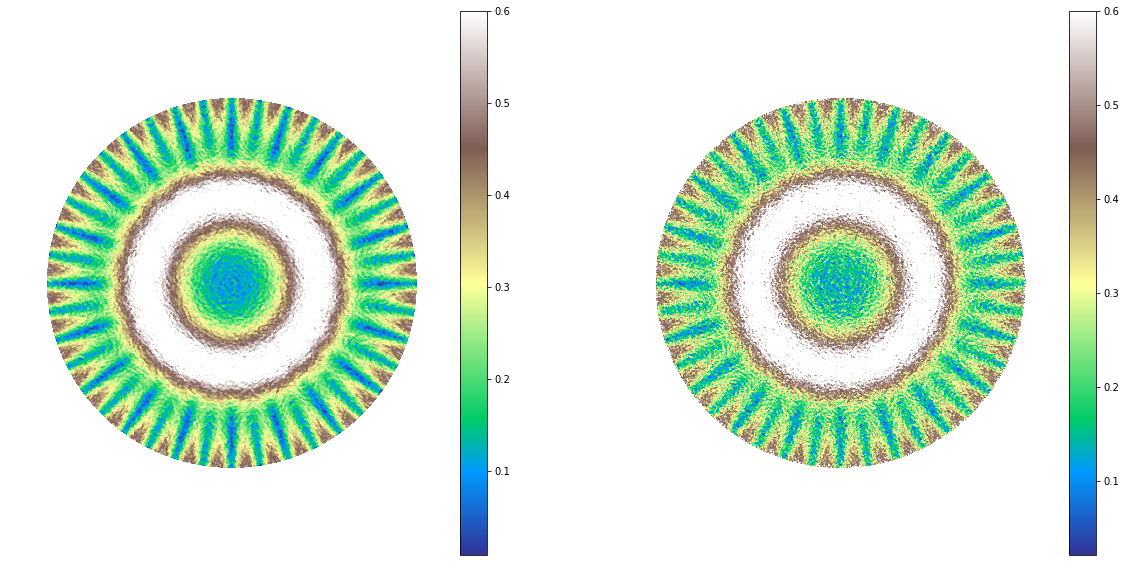

In [116]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
for ax in [ax1, ax2]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, slope5,    cmap='terrain', vmax=0.6)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, sp.slope,  cmap='terrain', vmax=0.6)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

## Timings for triangulation

``` python
x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 250000, 5000)
```

    Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
     - Delaunay triangulation 15.766856s
     - cKDTree 0.158748s
     - Calculate node weights and area 3.457745s
     - Compute edge lengths 0.463531s
     - Construct nearest neighbour array 1.639066s
     - Construct neighbour cloud array 1.485429s
     - Find boundaries 0.0570479999999s
     - Build smoothing matrix 0.102514s
     - Sort nodes by field 0.473859s
     - Build downhill matrices 1.335349s
     - Cumulative flow 1.344969s

``` python
x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 500000, 7500)
```


    Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
     - Delaunay triangulation 65.350717s
     - cKDTree 0.227902s
     - Calculate node weights and area 6.760594s
     - Compute edge lengths 1.023157s
     - Construct nearest neighbour array 3.306151s
     - Construct neighbour cloud array 2.833378s
     - Find boundaries 0.105048s
     - Build smoothing matrix 0.191309s
     - Sort nodes by field 0.880086s
     - Build downhill matrices 2.734977s
     - Cumulative flow 3.893042s
